In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xauusd-gold-price-historical-data-2004present/XAU_1d_data.csv
/kaggle/input/xauusd-gold-price-historical-data-2004present/XAU_1h_data.csv


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the hourly data
df = pd.read_csv('/kaggle/input/xauusd-gold-price-historical-data-2004present/XAU_1h_data.csv', sep=';')
df.head()

,Date,Open,High,Low,Close,Volume
0,2004.06.11 07:00,384.0,384.3,383.3,383.8,44
1,2004.06.11 08:00,383.8,384.3,383.1,383.1,41
2,2004.06.11 09:00,383.1,384.1,382.8,383.1,55
3,2004.06.11 10:00,383.0,383.8,383.0,383.6,33
4,2004.06.11 11:00,383.6,383.8,383.5,383.6,23


## 1. Data Preprocessing

In [6]:
# Set plot style for better visualization
plt.style.use('seaborn')
sns.set_palette("muted")

In [7]:
# Convert 'Date' column to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [9]:
# Check for duplicates
print("\nDuplicates:", df.duplicated().sum())


Duplicates: 41


In [10]:
# Drop duplicates
df = df.drop_duplicates()

In [11]:
# Basic info about the dataset
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121987 entries, 2004-06-11 07:00:00 to 2025-06-06 06:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    121987 non-null  float64
 1   High    121987 non-null  float64
 2   Low     121987 non-null  float64
 3   Close   121987 non-null  float64
 4   Volume  121987 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 5.6 MB


In [12]:
# Summary statistics
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
                 Open           High            Low          Close  \
count  121987.000000  121987.000000  121987.000000  121987.000000   
mean     1356.429721    1358.272068    1354.535259    1356.442918   
std       548.084998     548.810756     547.342130     548.113507   
min       381.300000     382.000000     381.100000     381.800000   
25%      1052.525000    1054.125000    1050.660000    1052.630000   
50%      1294.200000    1295.500000    1292.860000    1294.190000   
75%      1726.425000    1728.585000    1724.195000    1726.435000   
max      3494.260000    3499.940000    3479.420000    3494.250000   

              Volume  
count  121987.000000  
mean     3795.912310  
std      5685.666675  
min         1.000000  
25%       753.000000  
50%      2487.000000  
75%      4762.000000  
max    173826.000000  


In [13]:
# Resample to daily data (mean) to reduce noise for initial analysis
df_daily = df.resample('D').mean().dropna()

In [14]:
# Save a copy of the DataFrame for hyperparameter tuning
df_copy = df_daily.copy()

In [15]:
# Display the first few rows of the daily DataFrame
print("\nDaily Data Head:\n", df_daily.head())


Daily Data Head:
                   Open        High         Low       Close     Volume
Date                                                                 
2004-06-11  383.741667  384.208333  383.516667  383.758333  22.666667
2004-06-14  383.065217  383.626087  382.591304  382.995652  82.695652
2004-06-15  384.226087  384.934783  383.595652  384.313043  84.826087
2004-06-16  386.178261  386.847826  385.660870  386.143478  87.565217
2004-06-17  385.504348  386.295652  385.147826  385.743478  68.173913


## 2. Exploratory Data Analysis

In [16]:
# Set figure size for better readability
plt.rcParams['figure.figsize'] = (12, 8)

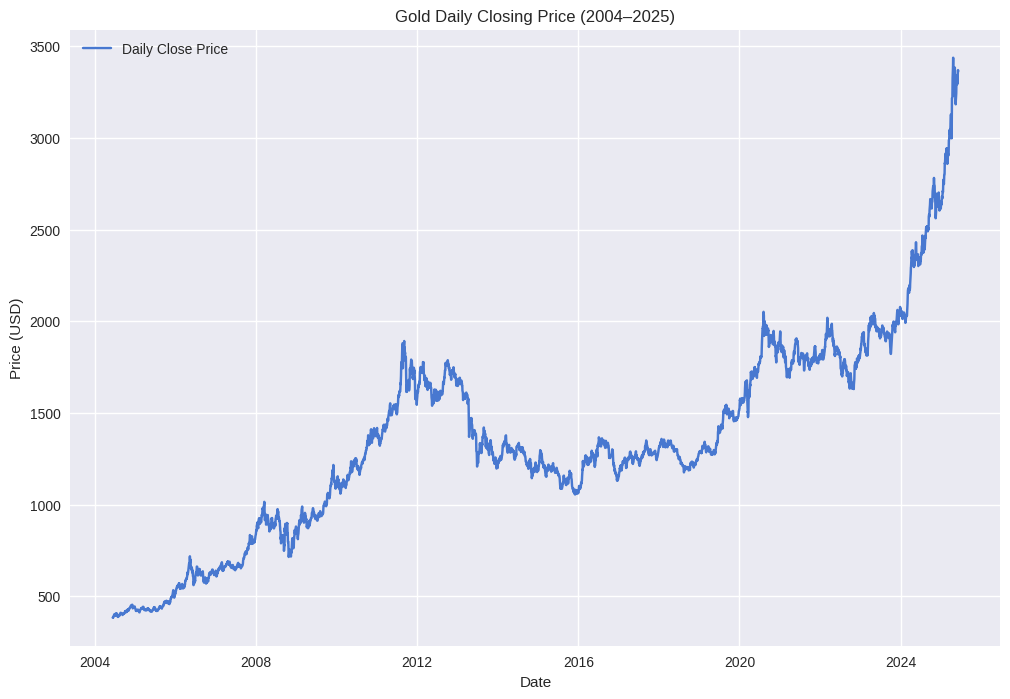

In [17]:
# Plot the closing price over time
plt.figure()
plt.plot(df_daily['Close'], label='Daily Close Price')
plt.title('Gold Daily Closing Price (2004–2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

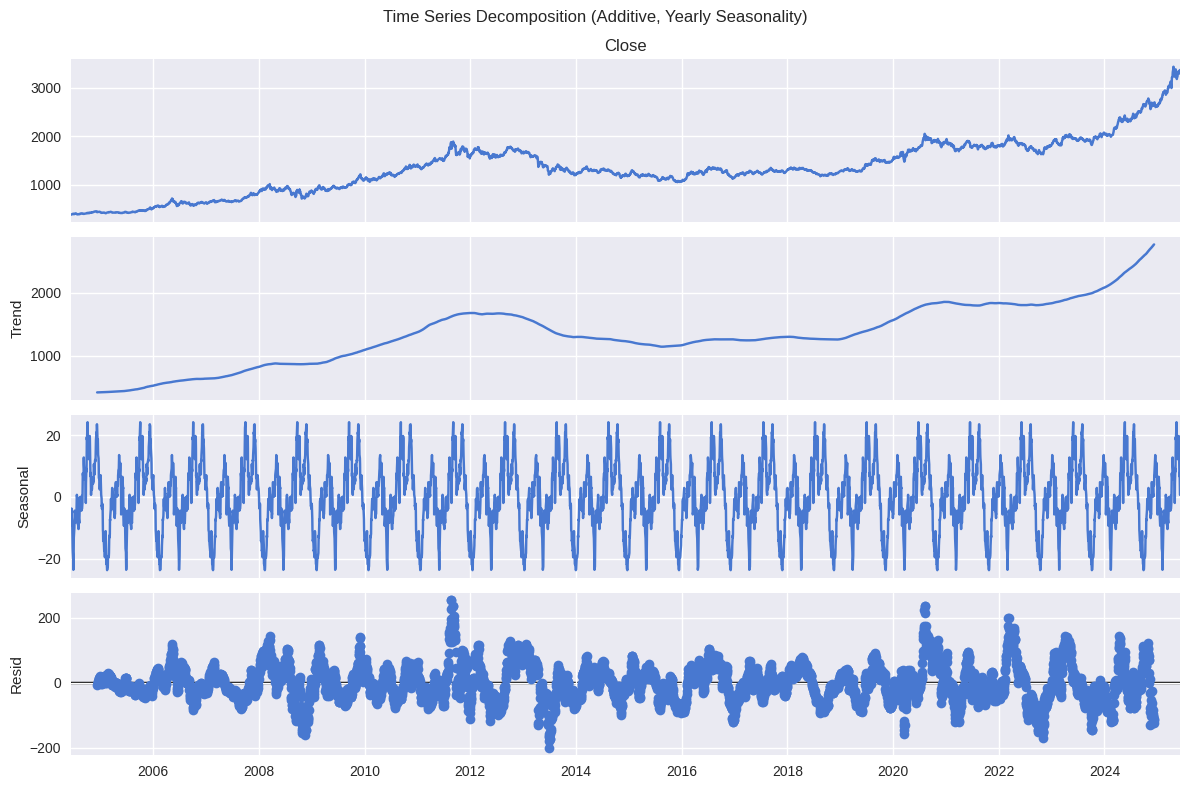

In [18]:
# Decompose the time series (assuming yearly seasonality, period=252 trading days)
decomposition = seasonal_decompose(df_daily['Close'], model='additive', period=252)
decomposition.plot()
plt.suptitle('Time Series Decomposition (Additive, Yearly Seasonality)')
plt.tight_layout()
plt.show()

In [19]:
# Perform ADF test for stationarity
adf_result = adfuller(df_daily['Close'])
print('ADF Test Results:')
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

ADF Test Results:
ADF Statistic: 2.0051
p-value: 0.9987
Critical Values:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671


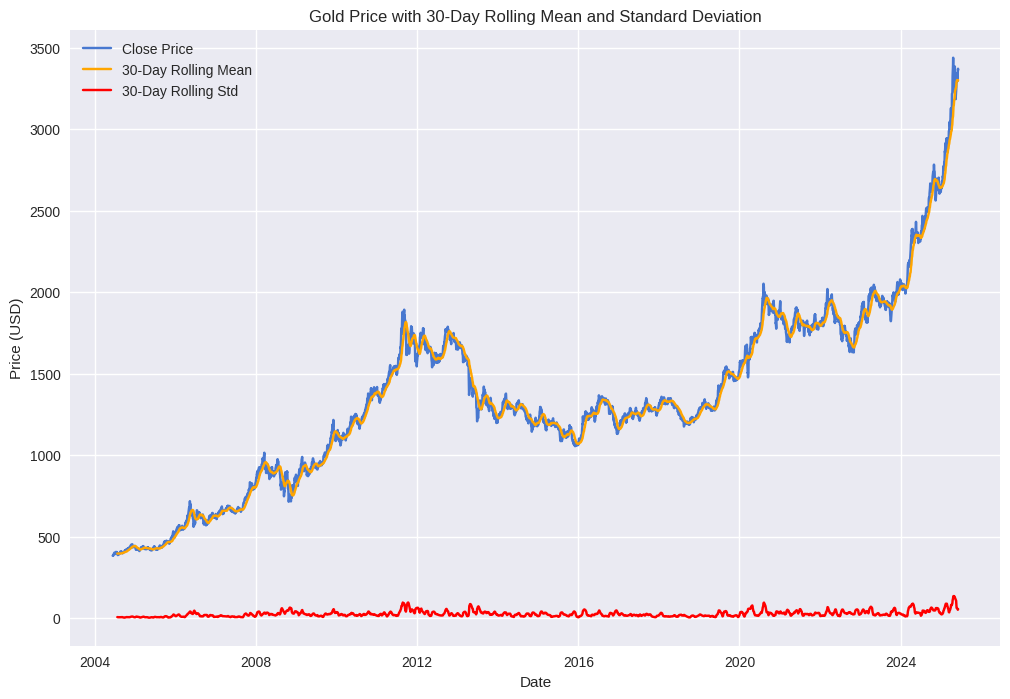

In [20]:
# Plot rolling mean and standard deviation (window = 30 days)
rolling_mean = df_daily['Close'].rolling(window=30).mean()
rolling_std = df_daily['Close'].rolling(window=30).std()

plt.figure()
plt.plot(df_daily['Close'], label='Close Price')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='orange')
plt.plot(rolling_std, label='30-Day Rolling Std', color='red')
plt.title('Gold Price with 30-Day Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

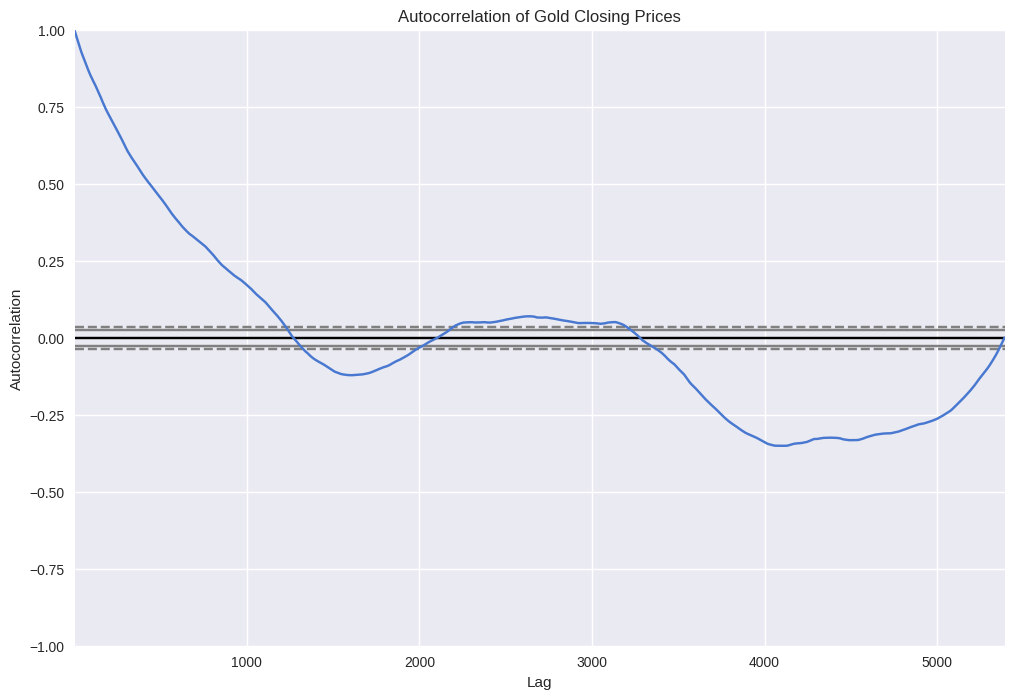

In [21]:
# Plot autocorrelation to check for lagged relationships
plt.figure()
autocorrelation_plot(df_daily['Close'])
plt.title('Autocorrelation of Gold Closing Prices')
plt.grid(True)
plt.show()

#### **Analysis of Results**

**1. Gold Daily Closing Price (2004–2025):**

- The time series shows a clear upward trend, with gold prices increasing from arounnd 400 USD in 2004 to over 3000 USD by 2025. Notable spikes occur around 2011–2012 and 2020–2021, likely reflecting economic uncertainty due to financial crisis or the COVID-19 pandemic.
- Volatility appears higher in recent years, which is a sign of increased market sensitivity or external influences.

**2. Time Series Decomposition:**

- **Trend:** Confirms a long-term upward movement, consistent with the raw price plot. The trend accelerates post-2020.
- **Seasonal:** The seasonal component shows small, irregular fluctuations (of about ±20 USD), a sign of weak yearly seasonality. This suggests that daily or weekly patterns may be more relevant, and the chosen period (252 days) might not fully capture the dominant seasonality.
- **Residual:** The residuals exhibit random noise with occasional spikes. This could be a potential sign that the additive model captures most of the structure, though some unexplained variability remains.

**3. Gold Price with 30-Day Rolling Mean and Standard Deviation:**

- The 30-day rolling mean smooths the trend, tracking the long-term increase and confirming the absence of strong cyclical reversals.
- The rolling standard deviation remains low until recent years, where it increases significantly. This reflects higher volatility and potential non-stationarity.

**4. Autocorrelation:**

- The autocorrelation drops sharply from 1.0 at lag 0 to near 0 within 500–1000 days, an indication of a strong short-to-medium-term dependence that diminishes over longer lags.
- Minor peaks at higher lags point to some long-term cyclicality, though it’s weak. This supports the inclusion of lagged features in modeling.

**5. ADF Test Results:**

- **ADF Statistic (2.0051):** Positive and far above the critical values (-3.4316, -2.8621, -2.5671 at 1%, 5%, 10% levels). This means that the series is not stationary.
- **p-value (0.9987):** The high p-value confirms non-stationarity, as it exceeds the typical threshold of 0.05. This means that differencing or transformations will be necessary before applying models like ARIMA.

## 3. Feature Engineering

In [22]:
# Log transformation to stabilize variance
df_daily['Close_Log'] = np.log(df_daily['Close'])

In [23]:
# First difference to address trend
df_daily['Close_Diff'] = df_daily['Close_Log'].diff().dropna()

In [24]:
# Create lagged features (1, 7, 14, 30 days)
for lag in [1, 7, 14, 30]:
    df_daily[f'Lag_{lag}'] = df_daily['Close_Log'].shift(lag)

# Rolling statistics (mean and std over 7 and 30 days)
df_daily['Roll_Mean_7'] = df_daily['Close_Log'].rolling(window=7).mean()
df_daily['Roll_Std_7'] = df_daily['Close_Log'].rolling(window=7).std()
df_daily['Roll_Mean_30'] = df_daily['Close_Log'].rolling(window=30).mean()
df_daily['Roll_Std_30'] = df_daily['Close_Log'].rolling(window=30).std()

In [25]:
# Drop NA values introduced by differencing and rolling
df_engineered = df_daily.dropna()

In [26]:
# Define features and target
features = ['Close_Diff', 'Lag_1', 'Lag_7', 'Lag_14', 'Lag_30', 
            'Roll_Mean_7', 'Roll_Std_7', 'Roll_Mean_30', 'Roll_Std_30']
target = 'Close_Log'

X = df_engineered[features]
y = df_engineered[target]

In [27]:
# Split into train and test sets (80-20 split, using the last 20% as test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Check stationarity of differenced series with ADF test
adf_diff = adfuller(df_engineered['Close_Diff'])
print('\nADF Test on Differenced Series:')
print(f'ADF Statistic: {adf_diff[0]:.4f}')
print(f'p-value: {adf_diff[1]:.4f}')
print('Critical Values:')
for key, value in adf_diff[4].items():
    print(f'   {key}: {value:.4f}')


ADF Test on Differenced Series:
ADF Statistic: -14.1744
p-value: 0.0000
Critical Values:
   1%: -3.4316
   5%: -2.8621
   10%: -2.5671


**ADF Test on Differenced Series:**

- **ADF Statistic (-14.1744):** The highly negative statistic, well below the critical values (-3.4316, -2.8621, -2.5671 at 1%, 5%, 10% levels), strongly indicates stationarity after differencing.
- **p-value (0.0000):** The p-value below 0.05 confirms the null hypothesis of non-stationarity can be rejected, therefore validating that the differenced log-transformed series is stationary. This makes it suitable for ARIMA or other time series models.

## 4. Model Selection and Training

In [29]:
# ARIMA Model
arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))

In [30]:
# XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [31]:
# LSTM Model

# Reshape data for LSTM [samples, timesteps, features]
timesteps = 1
X_train_lstm = X_train.values.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], timesteps, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(timesteps, X_train.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=0)

lstm_pred = lstm_model.predict(X_test_lstm)

2025-06-15 08:43:45.510140: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [32]:
# Calculate RMSE for each model
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred.flatten()))

print(f'ARIMA RMSE: {arima_rmse:.4f}')
print(f'XGBoost RMSE: {xgb_rmse:.4f}')
print(f'LSTM RMSE: {lstm_rmse:.4f}')

ARIMA RMSE: 0.2519
XGBoost RMSE: 0.1744
LSTM RMSE: 0.0282


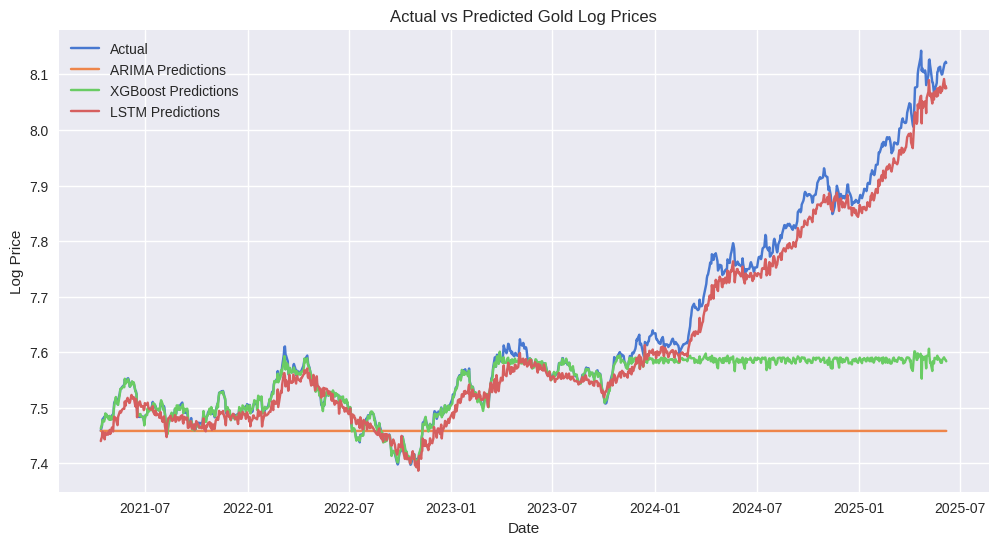

In [33]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, arima_pred, label='ARIMA Predictions')
plt.plot(y_test.index, xgb_pred, label='XGBoost Predictions')
plt.plot(y_test.index, lstm_pred, label='LSTM Predictions')
plt.title('Actual vs Predicted Gold Log Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend()
plt.grid(True)
plt.show()

Looks like LSTM is the best candidate for further tuning.

## 5. Hyperparameter Tuning

In [34]:
# Prepare the data from df_copy 
df_copy['Close_Log'] = np.log(df_copy['Close'])
df_copy['Close_Diff'] = df_copy['Close_Log'].diff().dropna()
for lag in [1, 7, 14, 30]:
    df_copy[f'Lag_{lag}'] = df_copy['Close_Log'].shift(lag)
df_copy['Roll_Mean_7'] = df_copy['Close_Log'].rolling(window=7).mean()
df_copy['Roll_Std_7'] = df_copy['Close_Log'].rolling(window=7).std()
df_copy['Roll_Mean_30'] = df_copy['Close_Log'].rolling(window=30).mean()
df_copy['Roll_Std_30'] = df_copy['Close_Log'].rolling(window=30).std()
df_tuned = df_copy.dropna()

features = ['Close_Diff', 'Lag_1', 'Lag_7', 'Lag_14', 'Lag_30', 
            'Roll_Mean_7', 'Roll_Std_7', 'Roll_Mean_30', 'Roll_Std_30']
target = 'Close_Log'

X_tuned = df_tuned[features]
y_tuned = df_tuned[target]

In [35]:
# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
best_rmse = float('inf')
best_params = {}

In [36]:
# Grid search over hyperparameters
param_grid = {
    'units': [50, 100],
    'epochs': [20, 50],
    'batch_size': [32, 64]
}

for units in param_grid['units']:
    for epochs in param_grid['epochs']:
        for batch_size in param_grid['batch_size']:
            rmse_scores = []
            for train_idx, test_idx in tscv.split(X_tuned):
                X_train, X_test = X_tuned.iloc[train_idx], X_tuned.iloc[test_idx]
                y_train, y_test = y_tuned.iloc[train_idx], y_tuned.iloc[test_idx]

                # Reshape for LSTM
                X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
                X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

                # Build and train model with early stopping
                model = Sequential()
                model.add(LSTM(units, activation='relu', input_shape=(1, X_train.shape[1])))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0, callbacks=[early_stopping])

                # Predict and calculate RMSE
                pred = model.predict(X_test_lstm, verbose=0)
                rmse = np.sqrt(mean_squared_error(y_test, pred))
                rmse_scores.append(rmse)

            mean_rmse = np.mean(rmse_scores)
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {'units': units, 'epochs': epochs, 'batch_size': batch_size}

print(f'Best RMSE: {best_rmse:.4f}')
print(f'Best Parameters: {best_params}')

Best RMSE: 0.0711
Best Parameters: {'units': 100, 'epochs': 50, 'batch_size': 32}


In [37]:
# Train final model with best parameters
X_train_final, X_test_final = X_tuned[:train_size], X_tuned[train_size:]
y_train_final, y_test_final = y_tuned[:train_size], y_tuned[train_size:]
X_train_lstm_final = X_train_final.values.reshape((X_train_final.shape[0], 1, X_train_final.shape[1]))
X_test_lstm_final = X_test_final.values.reshape((X_test_final.shape[0], 1, X_test_final.shape[1]))

final_model = Sequential()
final_model.add(LSTM(best_params['units'], activation='relu', input_shape=(1, X_train_final.shape[1])))
final_model.add(Dense(1))
final_model.compile(optimizer='adam', loss='mse')
final_model.fit(X_train_lstm_final, y_train_final, epochs=best_params['epochs'], 
                batch_size=best_params['batch_size'], verbose=0, 
                validation_split=0.1, callbacks=[early_stopping])

final_pred = final_model.predict(X_test_lstm_final, verbose=0)
final_rmse = np.sqrt(mean_squared_error(y_test_final, final_pred))

print(f'Final Model RMSE: {final_rmse:.4f}')

Final Model RMSE: 0.0223


## 6. Model Evaluation

In [44]:
# Ensure final_pred is 1D and matches y_test_final length
final_pred = final_pred.flatten()  # Flatten to 1D array
if len(final_pred) != len(y_test_final):
    raise ValueError(f"Length mismatch: final_pred ({len(final_pred)}) vs y_test_final ({len(y_test_final)})")

In [45]:
# Calculate additional metrics
final_mae = mean_absolute_error(y_test_final, final_pred)
final_mape = mean_absolute_percentage_error(y_test_final, final_pred) * 100
final_rmse = np.sqrt(mean_squared_error(y_test_final, final_pred))

print(f'Final Model Metrics:')
print(f'RMSE: {final_rmse:.4f}')
print(f'MAE: {final_mae:.4f}')
print(f'MAPE: {final_mape:.4f}%')

Final Model Metrics:
RMSE: 0.0223
MAE: 0.0179
MAPE: 0.2330%


In [46]:
# Inverse transform predictions to original scale for visualization
y_test_actual = np.exp(y_test_final)
final_pred_actual = np.exp(final_pred)

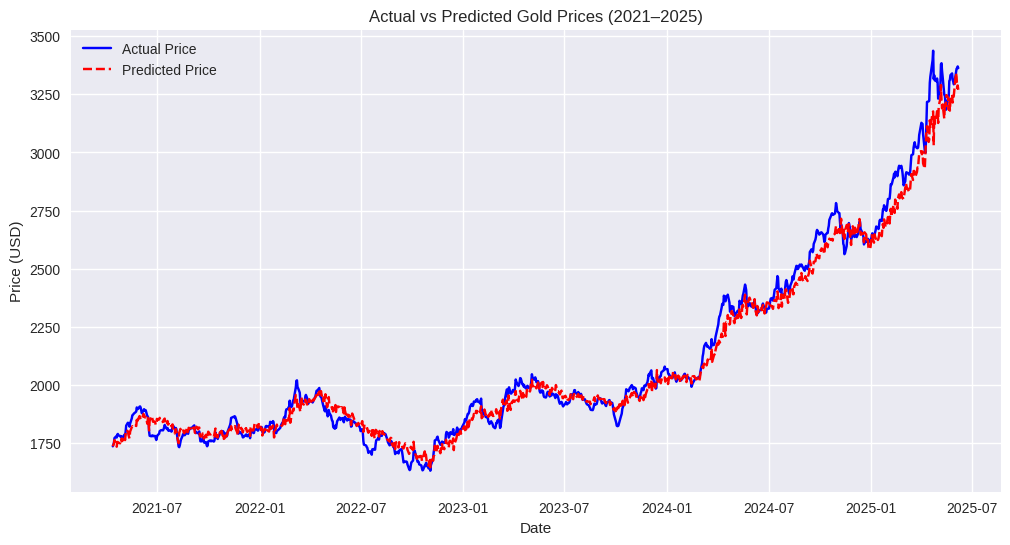

In [47]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_final.index, y_test_actual, label='Actual Price', color='blue')
plt.plot(y_test_final.index, final_pred_actual, label='Predicted Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Gold Prices (2021–2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()